In [1]:
from glob import glob
import os
import pickle
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
directory_path = "../../data/preprocessed"
output_dir = "../../data/batch"
def iterate_files(action, n=1):
    files = sorted(glob(os.path.join(directory_path, "events-*.pkl")))
    files = files[:n]
    
    for filename in tqdm(files, ncols=100, desc="Processing"):
        file_path = os.path.join(directory_path, filename)
        file_name = os.path.splitext(filename)[0]
    
        df = pd.read_pickle(file_path)
        action(file_name, df)

In [3]:
event_dates = []
def get_event_date(file_name, df):
    # add tuples of (id, date) to event_dates
    event_dates.extend([(i, row['info']['eventDate'], row['info']['articleCounts']['total']) for i, row in df.iterrows()])

In [4]:
iterate_files(get_event_date, 3000)

Processing:   0%|                                                          | 0/2944 [00:00<?, ?it/s]

Processing: 100%|███████████████████████████████████████████████| 2944/2944 [04:54<00:00, 10.00it/s]


In [5]:
event_df = pd.DataFrame(event_dates, columns=['id', 'event_date', 'count'])
event_df.set_index('id', inplace=True)
# sort df by event_date (desc)
event_df['event_date'] = event_df['event_date'].astype(int)
event_df['count'] = event_df['count'].astype(int)
event_df.sort_values(by='event_date', inplace=True, ascending=False)

In [6]:
def days_timestamp_to_date(days):
    # confirmed to be correct
    return pd.to_datetime(days, unit='D', origin=pd.Timestamp('1970-01-01')) 
# create a new column by applying days_timestamp_to_date to event_date
event_df['date'] = days_timestamp_to_date(event_df['event_date'])

In [9]:
event_df[event_df['event_date'] != 0].iloc[-100:]

,event_date,count,date
id,,,
e_659738,2274,8,1976-03-24
e_382106,2224,5,1976-02-03
e_836438,2151,8,1975-11-22
e_421104,2149,9,1975-11-20
e_911428,1910,8,1975-03-26
...,...,...,...
e_1973176,-3321,9,1960-11-28
e_1398704,-3384,23,1960-09-26
e_1092281,-3547,9,1960-04-16


In [7]:
with open('../../data/preprocessed/event_index.pkl', 'rb') as f:
    event_index = pickle.load(f)

<Axes: ylabel='Frequency'>

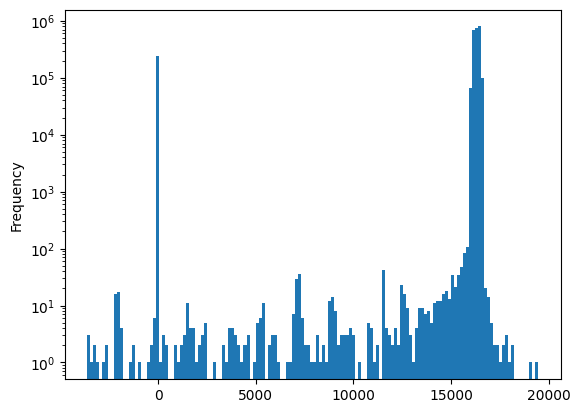

In [8]:
# plot the distribution of event_date on a log scale
event_df['event_date'].plot.hist(bins=150, log=True)

<Axes: ylabel='Frequency'>

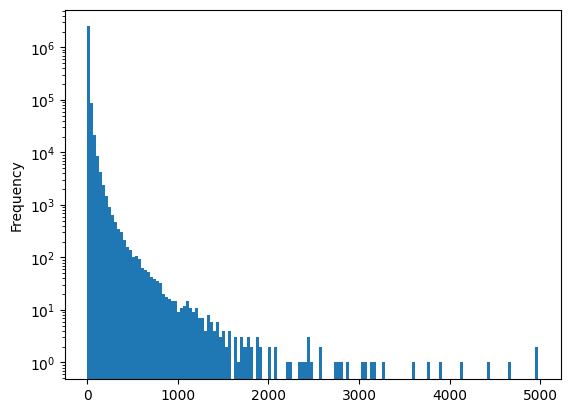

In [11]:
event_df['count'].plot.hist(bins=150, log=True)

In [28]:
def get_counts(df):
    counts = df['count']
    # counts = counts[counts >= 10]
    print(len(counts), counts.mean(), counts.median(), len(counts[counts < 40]), len(counts[counts >= 40]))
    counts.plot.hist(bins=150, log=True)

In [23]:
# 1.6.2014 in days
start = 16070
# 1.1.2016 in days
end = 16700
days_timestamp_to_date(start), days_timestamp_to_date(end)

(Timestamp('2013-12-31 00:00:00'), Timestamp('2015-09-22 00:00:00'))

In [44]:
events = event_df[(event_df['event_date'] >= start) & (event_df['event_date'] <= end)]
top_10 = events['event_date'].quantile(0.8)
recent_10 = events[events['event_date'] > top_10]
random_10 = events.sample(frac=0.1)

<Axes: ylabel='Frequency'>

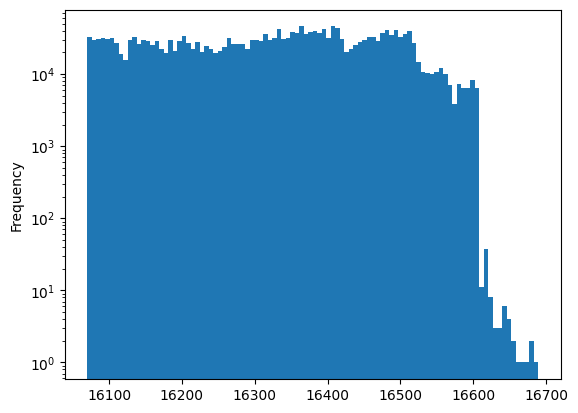

In [45]:
events['event_date'].plot.hist(bins=100, log=True)

In [89]:
events.shape, event_df.shape

((2335858, 3), (2632115, 3))

<Axes: ylabel='Frequency'>

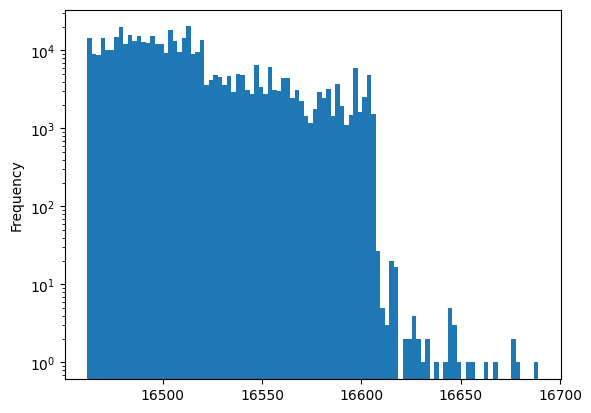

In [46]:
recent_10['event_date'].plot.hist(bins=100, log=True)

181935 24.99786737021464 13.0 134738 47197


<Axes: ylabel='Frequency'>

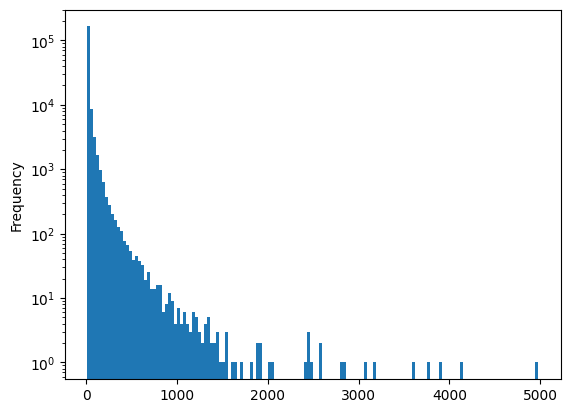

In [59]:
counts = recent_10['count']
# counts = counts[(counts >= 10) & (counts < 1000)]
counts = counts[counts >= 10]
print(len(counts), counts.mean(), counts.median(), len(counts[counts < 20]), len(counts[counts >= 20]))
counts.plot.hist(bins=150, log=True)

In [80]:
recent_high = recent_10[recent_10['count'] >= 25]

In [84]:
recent_med = recent_10[recent_10['count'] < 25]
recent_med = recent_med[recent_med['count'] >= 10]
recent_med = recent_med.sample(frac=0.2)

In [85]:
recent_low = recent_10[recent_10['count'] < 10]
recent_low = recent_low.sample(frac=0.1)

In [86]:
len(recent_low), len(recent_med), len(recent_high), len(recent_low) + len(recent_med) + len(recent_high)

(28402, 29406, 34905, 92713)

In [91]:
dataset = pd.concat([recent_low, recent_med, recent_high])

In [110]:
dataset[dataset['count'] == 6]

,event_date,count,date
id,,,
e_2466592,16478,6,2015-02-12
e_2651714,16501,6,2015-03-07
e_2815643,16529,6,2015-04-04
e_2673091,16509,6,2015-03-15
e_2886380,16564,6,2015-05-09
...,...,...,...
e_2823667,16532,6,2015-04-07
e_2484026,16480,6,2015-02-14
e_2891068,16567,6,2015-05-12


<Axes: ylabel='Frequency'>

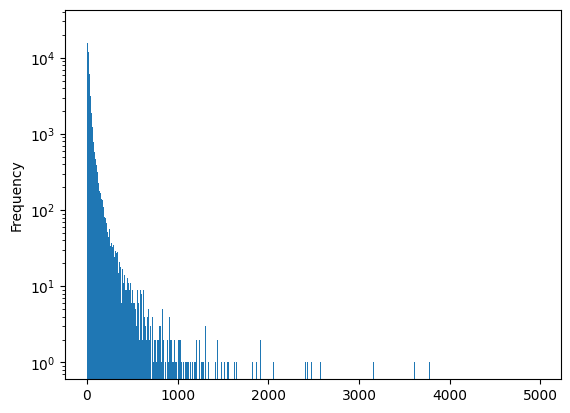

In [101]:
dataset['count'].plot.hist(bins=1000, log=True)

<Axes: ylabel='Frequency'>

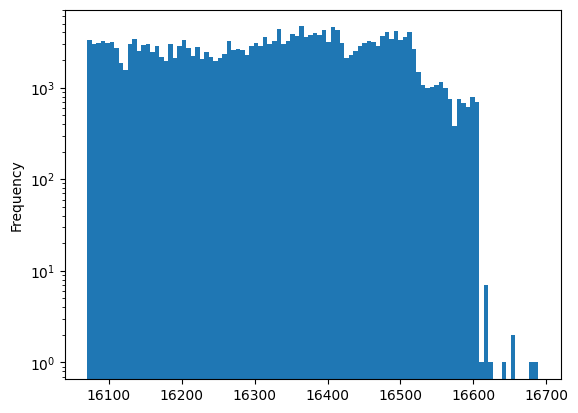

In [27]:
random_10['event_date'].plot.hist(bins=100, log=True)

In [111]:
def id_to_file_name(event_id):
    for file_name, event_ids in event_index.items():
        if event_id in event_ids:
            return file_name
    return None

In [119]:
recent_10 = dataset

In [113]:
# random_10['file_name'] = random_10.index.map(id_to_file_name)
# # groupby file_name and save to dict of file_name: set(event_ids)
# random_10_grouped = random_10.groupby('file_name')
# random_10_dict = {file_name: set(event_ids) for file_name, event_ids in random_10_grouped.groups.items()}

In [120]:
recent_10['file_name'] = recent_10.index.map(id_to_file_name)
# groupby file_name and save to dict of file_name: set(event_ids)
recent_10_grouped = recent_10.groupby('file_name')
recent_10_dict = {file_name: set(event_ids) for file_name, event_ids in recent_10_grouped.groups.items()}

In [115]:
# save to pickle
with open(os.path.join(output_dir, 'B_100k.pkl'), 'wb') as f:
    pickle.dump(recent_10_dict, f)
# # save to pickle
# with open(os.path.join(output_dir, 'B_random_10.pkl'), 'wb') as f:
#     pickle.dump(random_10_dict, f)

In [121]:
len(recent_10_dict.keys())

822

In [122]:
recent_10_dict.keys()

dict_keys(['events-00369', 'events-00726', 'events-01027', 'events-01241', 'events-01570', 'events-01573', 'events-01659', 'events-01932', 'events-01995', 'events-02029', 'events-02040', 'events-02043', 'events-02051', 'events-02058', 'events-02062', 'events-02064', 'events-02066', 'events-02067', 'events-02069', 'events-02070', 'events-02071', 'events-02072', 'events-02074', 'events-02075', 'events-02076', 'events-02077', 'events-02078', 'events-02079', 'events-02080', 'events-02081', 'events-02084', 'events-02085', 'events-02086', 'events-02087', 'events-02088', 'events-02091', 'events-02092', 'events-02093', 'events-02095', 'events-02096', 'events-02097', 'events-02100', 'events-02103', 'events-02104', 'events-02106', 'events-02107', 'events-02108', 'events-02109', 'events-02110', 'events-02111', 'events-02112', 'events-02113', 'events-02116', 'events-02117', 'events-02118', 'events-02119', 'events-02128', 'events-02142', 'events-02143', 'events-02145', 'events-02146', 'events-02147

In [123]:
recent_10.shape

(92713, 4)